In [1]:
%load_ext autoreload
%autoreload 2

### Import libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dash
from dash.dependencies import Input, Output
from dash import dcc, html
import plotly.graph_objs as go
import pickle
import os
import seaborn as sns
from prophet import Prophet

# import custom module
import preprocessing as scrb

# prevent logging when fitting Prophet models
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [ ]:
# How to handle deleting existing data when re-running the whole pipeline?

# Load Data From EIA, NOAA, and BLS

In [3]:
%run get_data.py "2018-06-19" "2024-02-16"
# run python script to load data and save to Datasets/prelim.csv

Requesting energy demand data from EIA over 10 requests
Requesting energy price data from EIA
Requesting Weather Data from NOAA
Requesting data from Bereau of Labor Statistics
All data loaded successfully. Saving preliminary dataset to Datasets/preliminary.csv
Preliminary dataset saved.


# Show Summary Information about Preliminary Dataset

In [4]:
# display summary of dataset
preliminary_data = pd.read_csv(r"Datasets/preliminary.csv", index_col=0)
desciptions = preliminary_data.describe().round(2)
cols_per_table = 6
for n in range(0,int(np.ceil(desciptions.shape[1]/cols_per_table))):
    # print(n*cols_per_table, (n*cols_per_table)+cols_per_table)
    display(desciptions.iloc[:,n*cols_per_table : (n*cols_per_table)+cols_per_table])

,Energy Demand (MWH),HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure
count,49627.00,47372.00,47381.00,44674.00,47372.00,47171.00
mean,5708.19,43.11,57.21,0.01,62.31,29.88
std,1224.60,19.12,16.84,0.05,19.59,0.23
min,0.00,-17.00,2.00,0.00,7.00,28.71
25%,4815.00,28.00,44.00,0.00,47.00,29.73
50%,5544.00,45.00,58.00,0.00,61.00,29.88
75%,6284.00,60.00,72.00,0.00,78.00,30.04
max,11069.00,79.00,95.00,3.47,100.00,30.59


,HourlyWetBulbTemperature,HourlyWindSpeed,Energy Price (cents/KWH),CPI-U,Unemployment Rate,Unemployment Level
count,47145.00,40215.00,47779.00,49266.00,48523.00,48523.00
mean,50.52,4.99,19.84,295.43,7.14,293521.00
std,15.63,19.62,1.96,17.72,3.97,156851.54
min,0.00,0.00,16.85,273.84,3.30,140697.00
25%,38.00,3.00,18.38,279.47,4.30,183574.00
50%,51.00,5.00,19.29,289.49,5.40,222617.00
75%,64.00,7.00,21.20,313.88,9.90,409961.00
max,81.00,2237.00,23.95,328.01,21.50,836383.00


,Employment Level,Labor Force Level,Employment Population Ratio,Labor Force Participation,Civilian Noninstitutional Population,Payroll Employment
count,48523.00,48523.00,48523.00,48523.00,48523.00,48523.00
mean,3853778.76,4147299.76,55.76,59.99,6915693.82,4465.78
std,238814.31,103952.79,3.58,1.72,174856.23,260.26
min,3046955.00,3707014.00,42.90,52.00,6641170.00,3748.60
25%,3712627.00,4085159.00,54.30,59.60,6746032.00,4225.70
50%,3897289.00,4122588.00,57.40,60.10,6918967.00,4563.10
75%,4076332.00,4254770.00,57.90,60.90,7107466.00,4661.90
max,4141201.00,4322118.00,59.10,62.80,7131615.00,4756.70


In [ ]:
preliminary_dataset = preliminary_dataset[["Energy Demand (MWH)", "HourlyDryBulbTemperature", 
    "HourlyPrecipitation", "HourlyWindSpeed", "Energy Price (Cents/KWH)", "Civilian Noninstitutional Population", 
    "CPI-U"]]

# Split dataset into training and holdout sets

In [5]:
prelim_training_data = scrb.split_preliminary_dataset(prelim_dataset=preliminary_data)

# Produce Raw Time Series Plots

In [7]:
scrb.raw_time_series_plots(prelim_training_data=prelim_training_data)

# Transform Variables

In [23]:
transformed_data = scrb.transform_variables(prelim_training_data)

### Identify Outliers and Produce Plots with Outliers Identified

In [30]:
# identify outliers
outliers_removed_data = scrb.identify_outliers(transformed_training_data=transformed_data)

/home/tobi/Desktop/Capstone/EnergyDemandForecasting/scrubbing.py:271: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/home/tobi/Desktop/Capstone/EnergyDemandForecasting/scrubbing.py:271: RuntimeWarning:

invalid value encountered in scalar divide



In [19]:
# Define available options for the dropdown menu
path_to_plots = r"Plotly Figures/Outlier Detection"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.pkl".format(path_to_plots, file_variable)})


# Initialize the Dash app
app = dash.Dash(__name__)


# Layout of the Dash app
app.layout = html.Div(children=[
    dcc.Dropdown(
        id='figure-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div([], id='output-graph')
])

# Callback to update the displayed graph based on dropdown selection
@app.callback(
    Output('output-graph', 'children'),
    [Input('figure-dropdown', 'value')]
)
def update_graph(selected_figure):
    # Unpickle the selected figure
    with open(selected_figure, 'rb') as f:
        figure_data = pickle.load(f)

    # Create the Plotly figure
    figure = go.Figure(figure_data)

    # Convert the Plotly figure to a Dash graph object
    graph = dcc.Graph(
        id='example-graph',
        figure=figure
    )

    return graph

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')


# Remove Outliers, Impute Missing Values, Transform Variables

In [124]:
# run function to clean dataset
clean_data = scrb.impute_missing_values(outliers_removed_data=outliers_removed_data)


Interpolating for variable Energy Demand (MWH)


22:16:12 - cmdstanpy - INFO - Chain [1] start processing
22:16:14 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDewPointTemperature


22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:22 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyDryBulbTemperature


22:16:28 - cmdstanpy - INFO - Chain [1] start processing
22:16:30 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyRelativeHumidity


22:16:36 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyStationPressure


22:16:44 - cmdstanpy - INFO - Chain [1] start processing
22:16:46 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWetBulbTemperature


22:16:52 - cmdstanpy - INFO - Chain [1] start processing
22:16:54 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable HourlyWindSpeed


22:17:00 - cmdstanpy - INFO - Chain [1] start processing
22:17:02 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Energy Price (cents/KWH)


22:17:08 - cmdstanpy - INFO - Chain [1] start processing
22:17:19 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable CPI-U


22:17:25 - cmdstanpy - INFO - Chain [1] start processing
22:17:47 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Rate


22:17:53 - cmdstanpy - INFO - Chain [1] start processing
22:18:06 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Unemployment Level


22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:35 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Level


22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Level


22:19:13 - cmdstanpy - INFO - Chain [1] start processing
22:19:33 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Employment Population Ratio


22:19:39 - cmdstanpy - INFO - Chain [1] start processing
22:19:53 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Labor Force Participation


22:19:58 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Civilian Noninstitutional Population


22:20:24 - cmdstanpy - INFO - Chain [1] start processing
22:20:42 - cmdstanpy - INFO - Chain [1] done processing


Interpolating for variable Payroll Employment


22:20:47 - cmdstanpy - INFO - Chain [1] start processing
22:21:01 - cmdstanpy - INFO - Chain [1] done processing


# Show Distributions for each Variable

In [ ]:
# run function to produce distribution plots
scrb.distribution_plots(clean_training_data=clean_data)

In [48]:
# dash app to show one distribution plot at a time
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Distributions"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image')
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File ~/miniforge3/envs/Capstone/lib/python3.11/site-packages/IPython/core/interactiveshell.py:310, in _modified_open(
    file='Static Visuals/Distributions/HourlyPrecipitation.png',
    *args=('rb',),
    **kwargs={}
)
    303 if file in {0, 1, 2}:
    304     raise ValueError(
    305         f"IPython won't let you open fd={file} by default "
    306         "as it is likely to crash IPython. If you know what you are doing, "
    307         "you can use builtins' open."
    308     )
--> 310 return io_open(file, *args, **kwargs)
        io_open = <built-in function open>
        file = 'Static Visuals/Distributions/HourlyPrecipitation.png'
        args = ('rb',)
        kwargs = {}

FileNotFoundError: [Errno 2] No such file or directory: 'Static Visuals/Distributions/HourlyPrecipitation.png'



# Show Scatter Plot between each Variable and Energy Demand

In [125]:
# run function to produce correlation plots
scrb.scatterplots(clean_training_data=clean_data)


TypeError: can only concatenate str (not "float") to str

In [126]:
# dash app to show one scatter plot at a time
# dash app to show one distribution plot at a time
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Scatterplots"
dropdown_options = []
for variable in preliminary_data.columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image')
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
File ~/miniforge3/envs/Capstone/lib/python3.11/site-packages/IPython/core/interactiveshell.py:310, in _modified_open(
    file='temp.png',
    *args=('rb',),
    **kwargs={}
)
    303 if file in {0, 1, 2}:
    304     raise ValueError(
    305         f"IPython won't let you open fd={file} by default "
    306         "as it is likely to crash IPython. If you know what you are doing, "
    307         "you can use builtins' open."
    308     )
--> 310 return io_open(file, *args, **kwargs)
        io_open = <built-in function open>
        file = 'temp.png'
        args = ('rb',)
        kwargs = {}

FileNotFoundError: [Errno 2] No such file or directory: 'temp.png'



# Show Time Series Decomposition for each Variable

In [118]:
# run function to produce (and save) time series decomposition plots
scrb.time_series_decompositions(clean_training_data=clean_data)

# dash app to show one time series decomposition plot at a time

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-

In [123]:
# Define available options for the dropdown menu
import base64
from PIL import Image
path_to_plots = r"Static Visuals/Decompositions"
dropdown_options = []
for variable in prelim_training_data.select_dtypes("number").columns:
    file_variable = variable.replace(r"/", "-")
    dropdown_options.append({"label":variable, "value":"{}/{}.png".format(path_to_plots, file_variable)})

# Initialize the Dash app
app = dash.Dash(__name__)

# Resize images to this width
IMAGE_WIDTH = 750

# Layout of the Dash app
app.layout = html.Div([
    dcc.Dropdown(
        id='image-dropdown',
        options=dropdown_options,
        value=dropdown_options[0]['value']  # Default value
    ),
    html.Div(id='output-image', style={'height': '800px'})
])

# Callback to update the displayed image based on dropdown selection
@app.callback(
    Output('output-image', 'children'),
    [Input('image-dropdown', 'value')]
)
def update_image(selected_image):
    # Read the image file
    with open(selected_image, 'rb') as f:
        img = Image.open(f)
        # Resize the image while preserving aspect ratio
        img.thumbnail((IMAGE_WIDTH, IMAGE_WIDTH))
        # Convert the image to RGBA if it's not already in that mode
        img = img.convert('RGBA')
        # Create a white background image to place the resized image on
        bg = Image.new('RGBA', (IMAGE_WIDTH, IMAGE_WIDTH), (255, 255, 255, 255))
        bg.paste(img, (int((IMAGE_WIDTH - img.width) / 2), int((IMAGE_WIDTH - img.height) / 2)), img)
        # Save the resized and centered image to a temporary file
        temp_image_path = 'temp.png'
        bg.save(temp_image_path)

    # Encode the resized image to base64 format
    with open(temp_image_path, 'rb') as f:
        encoded_image = base64.b64encode(f.read()).decode('utf-8')

    # Create an HTML img element with the encoded image
    image_element = html.Img(src='data:image/png;base64,{}'.format(encoded_image))

    # Delete the temporary image file
    os.remove(temp_image_path)

    return image_element

# Run the Dash app
if __name__ == '__main__':
    app.run(debug=True, host='127.0.0.1')

# Fit and Tune VARMA-GARCH Model on Prophet residuals

In [ ]:
# run function to tune VARMA-GARCH model and return best set of hyperparameters
# run function to fit (and save) VARMA-GARCH model using best set of hyperparameters

# dash app to show results?

In [51]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

data = outliers_removed_data.copy()
# Example data
variable = "Energy Demand (MWH)"
df = outliers_removed_data[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})

# Create and fit Prophet model
model = Prophet(seasonality_mode='additive')
model.fit(df)

21:06:36 - cmdstanpy - INFO - Chain [1] start processing
21:06:49 - cmdstanpy - INFO - Chain [1] done processing


In [80]:
display(df['y'].values - forecasts["yhat"].values)

array([1097.79760612, 1031.10947482, 1002.06386487, ...,  355.57183045,
        337.38301839,  292.14943932])

In [83]:
forecasts = model.predict(df)
forecasts.index = pd.to_datetime(outliers_removed_data.index)
forecasts['y'] = df['y'].values
forecasts["residual"] = df["y"].values - forecasts["yhat"].values

In [90]:
display((forecasts==-np.inf).sum())

ds                            0
trend                         0
yhat_lower                    0
yhat_upper                    0
trend_lower                   0
trend_upper                   0
additive_terms                0
additive_terms_lower          0
additive_terms_upper          0
daily                         0
daily_lower                   0
daily_upper                   0
weekly                        0
weekly_lower                  0
weekly_upper                  0
yearly                        0
yearly_lower                  0
yearly_upper                  0
multiplicative_terms          0
multiplicative_terms_lower    0
multiplicative_terms_upper    0
yhat                          0
y                             0
residual                      0
dtype: int64

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-

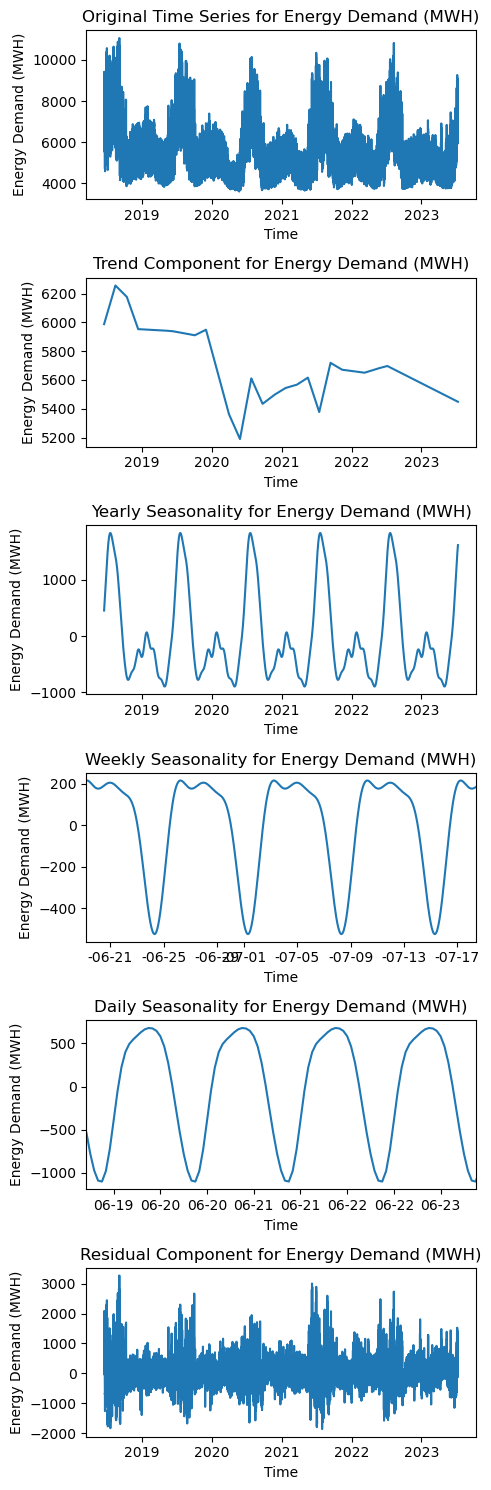

In [110]:
import seaborn as sns

# define figure
fig = plt.figure(figsize=(5,15))

# plot original time series
ax = fig.add_subplot(6,1,1)
sns.lineplot(x=forecasts["ds"].index, y=forecasts['y'])
ax.set_title("Original Time Series for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot trend component
ax = fig.add_subplot(6,1,2)
sns.lineplot(x = forecasts["ds"], y=forecasts["trend"])
ax.set_title("Trend Component for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot yearly seasonality
ax = fig.add_subplot(6,1,3)
sns.lineplot(x = forecasts["ds"], y=forecasts["yearly"])
ax.set_title("Yearly Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# plot weekly seasonality
ax = fig.add_subplot(6,1,4)
sns.lineplot(x = forecasts["ds"], y=forecasts["weekly"])
ax.set_title("Weekly Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)
# change axis limits
ax.set_xlim(forecasts["ds"].iloc[0], forecasts["ds"].iloc[100*7])
labels = [str(x)[-8:-2] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels)

# plot daily seasonlity
ax = fig.add_subplot(6,1,5)
sns.lineplot(x = forecasts["ds"], y=forecasts["daily"])
ax.set_title("Daily Seasonality for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)
# change axis limits
ax.set_xlim(forecasts["ds"].iloc[0], forecasts["ds"].iloc[100])
labels = [str(x)[-10:-5] for x in ax.get_xticklabels()]
ax.set_xticklabels(labels)

# plot residual component
ax = fig.add_subplot(6,1,6)
sns.lineplot(x = forecasts["ds"], y=forecasts["residual"])
ax.set_title("Residual Component for {}".format(variable))
ax.set_xlabel("Time")
ax.set_ylabel(variable)

# save figure
plt.tight_layout()
fig.show()

# Fit Autoregressive Model

In [3]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [51]:
model_training_data = pd.read_csv(r"Datasets/residuals.csv", index_col=0)
dummified_data = pd.get_dummies(model_training_data)

not_pca_vars = ["Energy Demand (MWH)", "HourlyDryBulbTemperature"]
not_pca_data = dummified_data[not_pca_vars]
pca_data = dummified_data.drop(columns=not_pca_vars)
display(not_pca_data)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# Perform PCA
pca = PCA(n_components=scaled_data.shape[1])  # You can choose the number of components you want to keep
pca.fit(scaled_data)

,Energy Demand (MWH),HourlyDryBulbTemperature
2018-06-19 05:00:00,944.824431,11.669587
2018-06-19 06:00:00,878.754744,12.162274
2018-06-19 07:00:00,850.262551,13.107193
2018-06-19 08:00:00,857.560358,12.587466
2018-06-19 09:00:00,885.916058,9.838335
...,...,...
2023-07-24 00:00:00,-491.140772,-0.524008
2023-07-24 01:00:00,-385.282019,-0.004949
2023-07-24 02:00:00,-196.401021,-0.519586
2023-07-24 03:00:00,-163.815838,-0.093374


PCA(n_components=18)

In [52]:
num_pcs_to_keep = sum(pca.explained_variance_ >= 1e-1)

# refit PCA with the desired number of principal components
pca = PCA(n_components=num_pcs_to_keep)  # You can choose the number of components you want to keep
pca.fit(scaled_data)


PCA(n_components=12)

In [53]:
# Transform the data using the fitted PCA
orthogonal_data = pca.transform(scaled_data)
orthogonal_data = pd.DataFrame(data=orthogonal_data, columns=["PC{}".format(x) for x in range(orthogonal_data.shape[1])], index=not_pca_data.index)
endogenous_data = pd.concat([not_pca_data, orthogonal_data], axis=1)

display(endogenous_data)


,Energy Demand (MWH),HourlyDryBulbTemperature,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2018-06-19 05:00:00,944.824431,11.669587,0.486303,1.991668,-0.591479,0.443497,0.465062,-0.383465,0.090693,-1.664878,-0.314792,0.797407,-0.268927,-0.345092
2018-06-19 06:00:00,878.754744,12.162274,0.465217,1.607274,-0.586746,0.431273,0.456120,-0.371160,0.085794,-1.682326,-0.336710,0.606908,-0.393011,-0.496940
2018-06-19 07:00:00,850.262551,13.107193,0.467446,1.493759,-0.567691,-0.253490,0.394388,-0.256603,0.048637,-1.483117,-0.571802,-0.004042,-0.490785,-0.598222
2018-06-19 08:00:00,857.560358,12.587466,0.448966,1.181578,-0.562860,-0.178367,0.386014,-0.262046,0.049504,-1.460875,-0.592305,-0.149244,-0.506753,-0.626145
2018-06-19 09:00:00,885.916058,9.838335,0.466519,1.476488,-0.584679,0.578239,0.443987,-0.394801,0.092163,-1.564817,-0.339051,0.632625,-0.246768,-0.325859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00,-491.140772,-0.524008,-0.980976,-1.357062,0.238865,1.245582,-0.829989,1.100004,-0.249097,-0.380580,0.178608,1.031364,0.261248,-0.635090
2023-07-24 01:00:00,-385.282019,-0.004949,-0.955159,-0.995564,0.242206,0.446202,-0.885203,1.214591,-0.285695,-0.127841,-0.035647,0.642533,0.281352,-0.594848
2023-07-24 02:00:00,-196.401021,-0.519586,-0.953680,-0.898499,0.230795,0.683814,-0.862698,1.170328,-0.271748,-0.172881,0.061913,0.930608,0.345423,-0.525699
2023-07-24 03:00:00,-163.815838,-0.093374,-0.958099,-0.979657,0.228209,0.913731,-0.843044,1.137184,-0.261872,-0.257547,0.162374,1.185248,0.300593,-0.577440


In [54]:
display(endogenous_data.index.dtype)

dtype('O')

<Axes: xlabel='None', ylabel='PC0'>

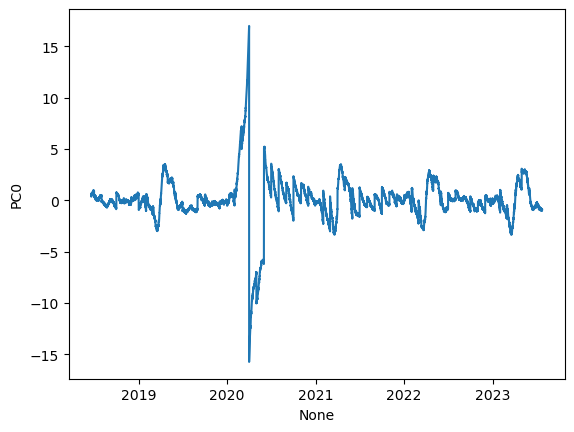

In [55]:
sns.lineplot(x=pd.to_datetime(endogenous_data.index), y = endogenous_data["PC0"])

In [56]:
# Fit VAR model
point_var_model = VAR(endogenous_data)
point_var_result = point_var_model.fit()

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [167]:
# Check the summary of the model
# print(result.summary())
# display(result.params)
# display(endogenous_data.iloc[1:])
# display(result.resid)
errors = endogenous_data.values[1:] - point_var_result.resid.values
# display(errors)
# get squared errors
squared_errors = pd.DataFrame(data=(errors**2), columns=endogenous_data.columns, index=endogenous_data.index[1:])
display(squared_errors)

,Energy Demand (MWH),HourlyDryBulbTemperature,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2018-06-19 06:00:00,871900.769254,127.552246,0.235389,3.921217,0.337637,0.003178,0.184649,0.089085,0.022734,1.792358,0.247312,0.188757,0.077209,0.121213
2018-06-19 07:00:00,756366.774967,136.994946,0.215673,2.542727,0.333498,0.005479,0.189350,0.079673,0.021015,1.940843,0.250646,0.084812,0.146102,0.228294
2018-06-19 08:00:00,710078.803455,160.457856,0.213868,2.105407,0.321635,0.058277,0.168505,0.051677,0.012450,1.872486,0.360434,0.001150,0.218490,0.329242
2018-06-19 09:00:00,722317.520359,146.401427,0.197837,1.318716,0.317138,0.022173,0.163791,0.056277,0.010965,1.851358,0.373302,0.024410,0.233425,0.361648
2018-06-19 10:00:00,766053.694053,89.289033,0.217599,2.184056,0.330696,0.040556,0.167566,0.099102,0.020150,1.576998,0.262022,0.085411,0.065892,0.108618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00,175831.889179,0.002806,0.858963,0.878592,0.083533,0.127347,1.007141,1.746240,0.123384,0.024401,0.119192,0.000164,0.062547,0.339894
2023-07-24 01:00:00,231628.004101,0.680023,0.934503,1.515614,0.062749,0.392109,0.828090,1.372747,0.077047,0.008007,0.001523,0.338140,0.066093,0.383088
2023-07-24 02:00:00,142357.480453,0.024962,0.895393,0.829588,0.060502,0.036616,0.874849,1.501674,0.088434,0.000111,0.016304,0.203728,0.076827,0.346188
2023-07-24 03:00:00,36984.046039,0.438190,0.889198,0.639167,0.056554,0.084265,0.859547,1.449068,0.078935,0.001321,0.006888,0.392018,0.109815,0.278049


# Fit GARCH model on squared errors

In [203]:
# fit Prophet model for each variable included in the VAR model
error_prophet_models = {}
error_residuals = squared_errors.copy()
error_multiples = squared_errors.copy()
error_forecasts = squared_errors.copy()
for variable in squared_errors.columns:
    df = squared_errors[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})

    # define prophet model with all seasonality components and high regularization
    error_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=True, 
        changepoint_prior_scale=0.001, seasonality_prior_scale=0.01)
    
    # fit model
    error_model.fit(df)

    forecasts = error_model.predict(df)
    forecasts.index = pd.to_datetime(squared_errors.index)
    forecasts["yhat"] = np.maximum(0, forecasts["yhat"].values) # adjust forecasts to be positive
    print(forecasts["yhat"].min())
    forecasts['y'] = df['y'].values
    forecasts["residual"] = df["y"].values - forecasts["yhat"].values
    forecasts["multiple"] = forecasts["yhat"].values / df["y"].values

    error_prophet_models[variable] = error_model

    error_forecasts.loc[:,variable] = forecasts["yhat"].values
    error_residuals.loc[:,variable] = forecasts["residual"].values
    error_multiples.loc[:,variable] = forecasts["multiple"].values
error_prophet_model = error_prophet_models["Energy Demand (MWH)"]


# fit VAR model for squared errors using residuals from Prophet models

0.0
6.357029317352975
0.0
0.26041288245421823
0.0
0.08197501511101668
0.0
0.0
0.0
0.12990075688878755
0.0
0.12869929074410685
0.0
0.0


In [195]:
df = squared_errors[["Energy Demand (MWH)"]].reset_index().rename(columns={"index":"ds", variable:"y"})
forecasts = error_prophet_model.predict(df)

In [202]:
display(np.maximum(forecasts["yhat"], 0).min())

0.0

In [194]:
display(error_forecasts.min())

-228350.01791405742

In [171]:
t = error_multiples["Energy Demand (MWH)"].copy()
t[t>100] = 100
display(t.min())
display(t.max())

0.0

100.0

In [172]:
display(t)
# display(error_residuals.values[:,0].min())


2018-06-19 06:00:00     0.779553
2018-06-19 07:00:00     0.893573
2018-06-19 08:00:00     0.945254
2018-06-19 09:00:00     0.917794
2018-06-19 10:00:00     0.850435
                         ...    
2023-07-24 00:00:00     3.439612
2023-07-24 01:00:00     2.444699
2023-07-24 02:00:00     3.808326
2023-07-24 03:00:00    14.344828
2023-07-24 04:00:00    20.497729
Name: Energy Demand (MWH), Length: 44663, dtype: float64

<Axes: xlabel='Energy Demand (MWH)', ylabel='Count'>

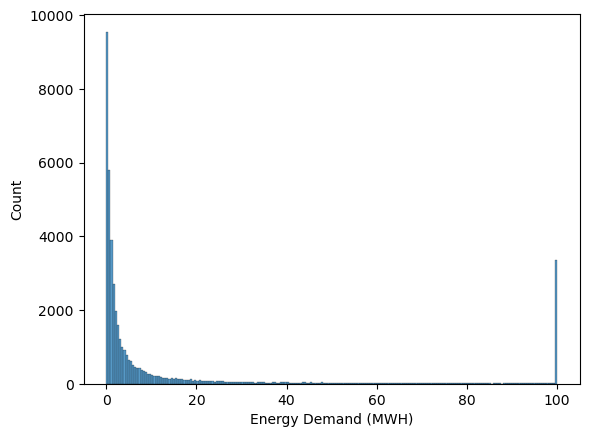

In [173]:
sns.histplot(t)

<Axes: xlabel='None', ylabel='yhat'>

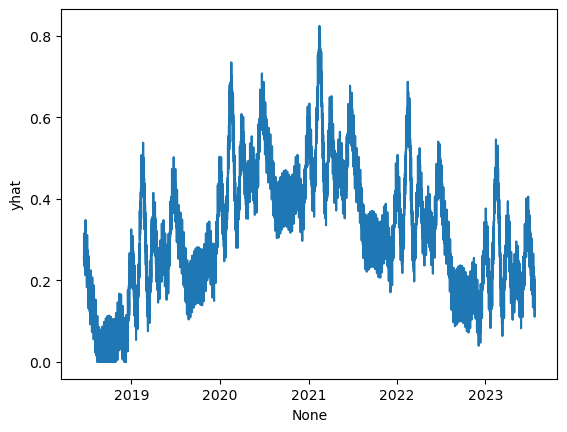

In [94]:
df = squared_errors[[variable]].reset_index().rename(columns={"index":"ds", variable:"y"})
forecasts = error_model.predict(df)
forecasts.index = pd.to_datetime(squared_errors.index)
sns.lineplot(x=forecasts.index, y=np.maximum(0, forecasts["yhat"]))


In [178]:
display(error_residuals)
# sns.histplot(error_residuals.iloc[:,0])

,Energy Demand (MWH),HourlyDryBulbTemperature,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
2018-06-19 06:00:00,192208.162129,104.551399,-2.057592,2.211125,0.337637,-0.275596,0.075519,0.049038,0.003070,1.329654,-0.719759,-0.245947,-0.097369,-0.135130
2018-06-19 07:00:00,80498.135383,114.744959,-2.075622,0.855763,0.333498,-0.275226,0.085478,0.042319,0.004617,1.488634,-0.713749,-0.355791,-0.023396,-0.021615
2018-06-19 08:00:00,38873.966017,138.842267,-2.077019,0.434304,0.321635,-0.231682,0.070585,0.016297,0.002517,1.426860,-0.603092,-0.440890,0.050237,0.081944
2018-06-19 09:00:00,59378.872008,124.455430,-2.093873,-0.351955,0.317138,-0.275894,0.070033,0.021685,0.007250,1.402325,-0.589180,-0.417084,0.059080,0.109210
2018-06-19 10:00:00,114575.160751,65.593491,-2.074533,0.497085,0.330696,-0.259186,0.074892,0.064051,0.018192,1.115337,-0.697404,-0.358061,-0.122169,-0.157639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24 00:00:00,-428961.669278,-18.203641,0.858963,0.261004,0.083533,-0.127558,0.214321,0.298755,-0.001129,-0.320196,-0.315238,-0.222661,-0.028280,0.174234
2023-07-24 01:00:00,-334632.844589,-17.893700,0.934503,0.881459,0.062749,0.118441,0.035470,-0.073034,-0.047882,-0.329493,-0.432392,0.112926,-0.018447,0.216323
2023-07-24 02:00:00,-399786.236068,-18.936738,0.895393,0.185741,0.060502,-0.254613,0.081290,0.058118,-0.035322,-0.338081,-0.421157,-0.020024,-0.003997,0.177176
2023-07-24 03:00:00,-493545.749180,-19.034743,0.889198,-0.004751,0.056554,-0.213179,0.063991,0.008652,-0.043045,-0.346577,-0.436194,0.171179,0.030692,0.106607


In [225]:
# Fit error VAR model
# t = error_multiples.copy()
# t[t>100] = 100
error_var_model = VAR(error_residuals)
error_var_result = error_var_model.fit()
# error_var_model = VAR(t)
# error_var_result = error_var_model.fit()

/home/tobi/miniforge3/envs/Capstone/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.



In [158]:
# load holdout data
evaluation_data = pd.read_csv(r"Datasets/holdout.csv", index_col=0)
evaluation_data.index = pd.to_datetime(evaluation_data.index)
display(evaluation_data.shape)

(4963, 1)

In [159]:
# make point forecasts with Prophet
import pickle as pkl
with open(r"Models/Prophet/Energy Demand (MWH).pkl", "rb") as file:
    point_prophet_model = pkl.load(file)
df = point_prophet_model.make_future_dataframe(periods=evaluation_data.shape[0]+1, freq="H")
point_prophet_forecasts = point_prophet_model.predict(df)[["ds", "yhat"]]
point_prophet_forecasts = point_prophet_forecasts[point_prophet_forecasts["ds"].isin(evaluation_data.index)]["yhat"].values
display(point_prophet_forecasts.shape)

(4963,)

In [153]:
# make point forecasts with VAR
point_var_forecasts = point_var_result.forecast(endogenous_data.values[-point_var_result.k_ar:], steps=evaluation_data.shape[0])[:,0]
display(forecasts.shape)

(4963,)

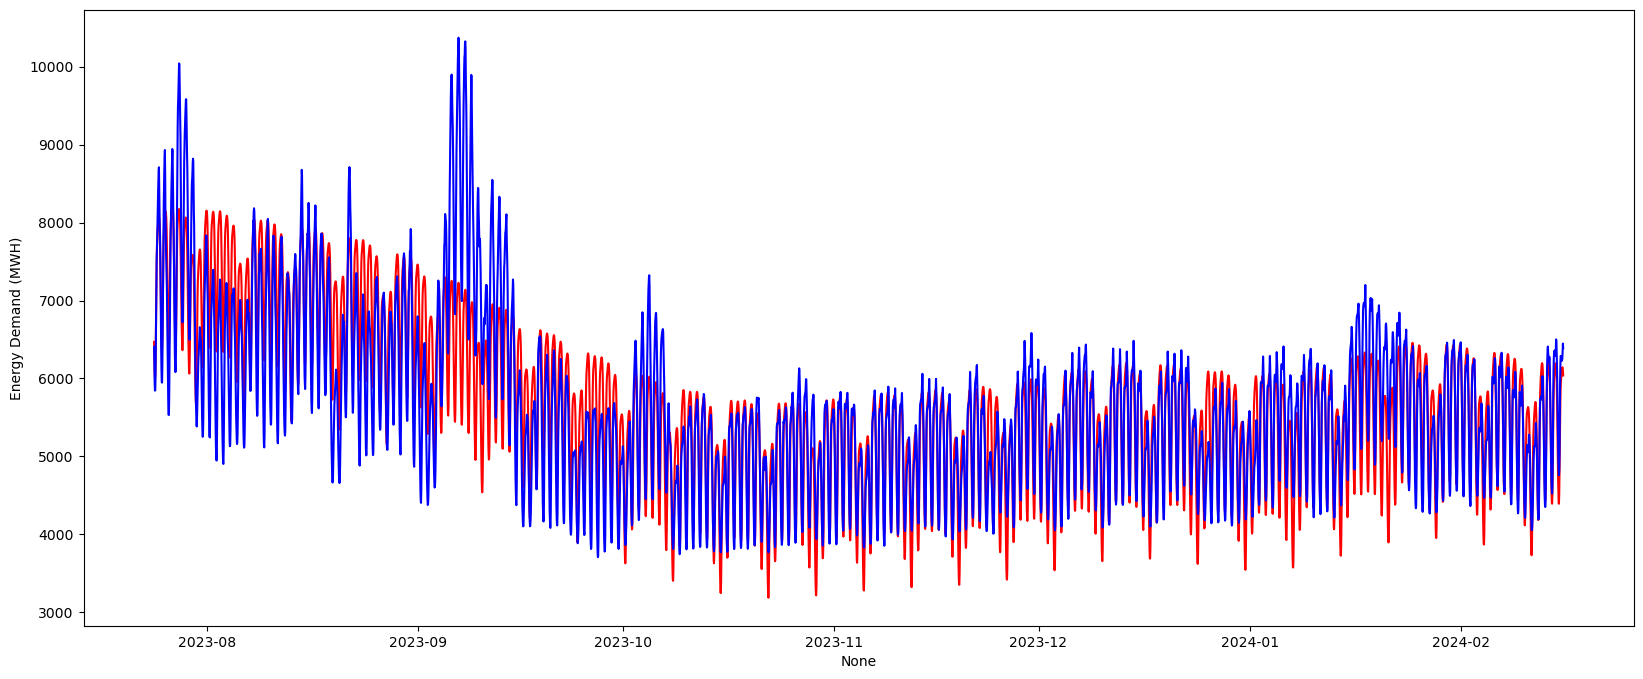

In [163]:
# Combine point forecasts
point_forecasts = point_prophet_forecasts + point_var_forecasts

fig = plt.figure(figsize=(20,8))
sns.lineplot(x=evaluation_data.index, y=point_forecasts, color = "red")
sns.lineplot(x=evaluation_data.index, y=evaluation_data["Energy Demand (MWH)"], color="blue")
plt.show()

In [231]:
med_squared_error = squared_errors["Energy Demand (MWH)"].median()
display(med_squared_error)

75828.2269660332

In [232]:
# make error forecasts
df = error_prophet_model.make_future_dataframe(periods=evaluation_data.shape[0]+1, freq="H")
error_prophet_forecasts = error_prophet_model.predict(df)[["ds", "yhat"]]
error_prophet_forecasts = error_prophet_forecasts[error_prophet_forecasts["ds"].isin(evaluation_data.index)]["yhat"].values
# error_prophet_forecasts = np.maximum(200**2, error_prophet_forecasts) # make positive
error_prophet_forecasts = np.maximum(med_squared_error, error_prophet_forecasts) # make positive
display(error_prophet_forecasts.shape)

(4963,)

In [207]:
# make error var forecasts
error_var_forecasts = error_var_result.forecast(t.values[-error_var_result.k_ar:], steps=evaluation_data.shape[0])[:,0]
display(error_var_forecasts.shape)

(4963,)

In [208]:
display(error_prophet_forecasts.min())
display(error_prophet_forecasts.max())
display(np.isnan(error_prophet_forecasts).sum())

1.0

784707.5363312069

0

In [219]:
display(np.sqrt(error_forecasts).min())

10.0

In [233]:
# Combine error forecasts
error_forecasts = error_prophet_forecasts #+ error_var_forecasts
std_forecasts = np.sqrt(error_forecasts)
lower_cuts = point_forecasts - 1.96 * std_forecasts  # 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
upper_cuts = point_forecasts + 1.96 * std_forecasts

# fig = plt.figure(figsize=(20,8))
# sns.lineplot(x=evaluation_data.index, y=point_forecasts, color = "red")
# sns.lineplot(x=evaluation_data.index, y=evaluation_data["Energy Demand (MWH)"], color="blue")
# sns.lineplot(x=evaluation_data.index, y=lower_cuts, color = "black")
# sns.lineplot(x=evaluation_data.index, y=upper_cuts, color = "black")
# plt.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=evaluation_data.index, y=point_forecasts, mode='lines', name='Point Forecasts'))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=evaluation_data["Energy Demand (MWH)"], mode='lines', name='Ground Truth'))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=lower_cuts, mode='lines', name='Upper 95 CI'))
fig.add_trace(go.Scatter(x=evaluation_data.index, y=upper_cuts, mode='lines', name='Lower 95 CI'))

# Customize the layout
fig.update_layout(
    title='Outlier Identification for {}'.format(variable),
    xaxis_title='Time',
    yaxis_title='{}'.format(variable),
    template='plotly_dark'  # Use a dark theme
)


In [ ]:






# get ground truth values

# plot both

In [143]:
error_predictions = error_forecasts.values[1:] #+ error_residuals.values[1:]/error_multiples.values[1:]
display(error_predictions)
# sns.histplot(error_predictions[:,0])

array([[6.75868640e+05, 2.22499875e+01, 2.29129440e+00, ...,
        4.40602985e-01, 1.69497576e-01, 2.49908354e-01],
       [6.71204837e+05, 2.16155895e+01, 2.29088644e+00, ...,
        4.42040302e-01, 1.68253680e-01, 2.47298002e-01],
       [6.62938648e+05, 2.19459969e+01, 2.29170992e+00, ...,
        4.41494082e-01, 1.74345252e-01, 2.52438697e-01],
       ...,
       [5.42143717e+05, 1.89616996e+01, 0.00000000e+00, ...,
        2.23752630e-01, 8.08243800e-02, 1.69011598e-01],
       [5.30529795e+05, 1.94729337e+01, 0.00000000e+00, ...,
        2.20839146e-01, 7.91228347e-02, 1.71442649e-01],
       [5.24314983e+05, 2.01379875e+01, 0.00000000e+00, ...,
        2.20675763e-01, 7.75452417e-02, 1.73016303e-01]])

In [64]:
# combine models


,Energy Demand (MWH)
2023-07-24 05:00:00,6406.0
2023-07-24 06:00:00,6149.0
2023-07-24 07:00:00,5941.0
2023-07-24 08:00:00,5845.0
2023-07-24 09:00:00,5846.0
...,...
2024-02-15 20:00:00,6238.0
2024-02-15 21:00:00,6255.0
2024-02-15 22:00:00,6346.0
2024-02-15 23:00:00,6448.0


In [73]:
# seasonal point forecasts
# clean_data = pd.read_csv(r"Datasets/clean_training.csv", index_col=0)
# df = outliers_removed_data[["Energy Demand (MWH)"]].reset_index().rename(columns={"index":"ds", variable:"y"})
df = point_prophet_model.make_future_dataframe(periods=evaluation_data.shape[0]+1, freq="H")
display(point_prophet_model.predict(df)[["ds", "yhat"]])
# display(df)

# autoregressive point forecasts

,ds,yhat
0,2018-06-19 05:00:00,6276.175569
1,2018-06-19 06:00:00,6032.245256
2,2018-06-19 07:00:00,5840.737449
3,2018-06-19 08:00:00,5724.439642
4,2018-06-19 09:00:00,5714.083942
...,...,...
49623,2024-02-15 20:00:00,6133.809311
49624,2024-02-15 21:00:00,6146.432587
49625,2024-02-15 22:00:00,6138.213143
49626,2024-02-15 23:00:00,6107.193765


# Define Linear Forecasting Model

In [ ]:
# split into two parts: point forecaster and variance forecaster

# point forecaster needs to have Prophet model for energy demand and VAR model

# variance forecaster needs to have Prophet model for energy demand and VAR model

# based on cross-validation data, add small trend to variance Prophet model

# function to predict using all 